In [196]:
% matplotlib inline
import pylab as plt
import numpy as np
import networkx as nx
import pandas as pd
import operator
import os
import re
from glob import glob
import os
os.chdir('/home/jagust/dino/surf/')
import util as util
import modularity as md
import btc as btc
import scipy
import operator

~ Monday 29 June 2015 ~

In [103]:
# Import Matrices
fmat = np.load('/home/jagust/dino/surf/thr_func_group_mat.npy')
fmat_neg = np.load('/home/jagust/dino/surf/thr_neg_func_mat.npy')
fmat_pos = np.load('/home/jagust/dino/surf/thr_pos_func_mat.npy')
pibmat = np.load('/home/jagust/dino/surf/pib_mat.npy')

pibmatpos = np.load('/home/jagust/dino/surf/neg_pib_mat.npy')
pibmatneg = np.load('/home/jagust/dino/surf/pos_pib_mat.npy')

In [4]:
# Functional Network Formation
fnet = nx.from_numpy_matrix(fmat)
fnet_neg = nx.from_numpy_matrix(fmat_neg)
fnet_pos = nx.from_numpy_matrix(fmat_pos)

In [5]:
# PiB Netowrk Formation
pibnet = nx.from_numpy_matrix(pibmat)

In [105]:
def remove_neg_weight_edges(g):
    for edge in g.edges(data = True):
        if edge[2]['weight'] < 0.0:
            g.remove_edge(edge[0], edge[1])

In [49]:
remove_neg_weight_edges(pibnet)

In [104]:
pibnetpos = nx.from_numpy_matrix(pibmatpos)
pibnetneg = nx.from_numpy_matrix(pibmatneg)

In [106]:
remove_neg_weight_edges(pibnetpos)
remove_neg_weight_edges(pibnetneg)

Simulation
======

1) Find node with highest degree in PiB Network<br/>
2) Remove node from functional network<br/>
3) Find node that has correlates "strongest" with set of previously removed nodes<br/>
4) Go to step 2

In [6]:
# Find node with highest degree in PiB Network
pib_nodes = pibnet.nodes()
degs = {}
for node in range(len(pib_nodes)):
    degs[node] = 0.0
    for edge in pibnet.edges(node, data = True):
        degs[node] += edge[2]['weight']

In [7]:
def sort_by_val(d):
    return sorted(d.items(), key = operator.itemgetter(1))

In [8]:
d = sort_by_val(degs)[::-1]
seed = d[0][0]
print "Seed: " + str(seed)

Seed: 55


In [89]:
def find_next_node(r, g):
    """ Find the next node to be removed in the simulation
    
    Parameters
    ----------
        r : set of removed nodes
        
    Returns
    -------
        node : next node to be removed
    """
    nodes = g.nodes()
    distance = {}
    for node in nodes:
        if node in r:
            continue
        distance[node] = 0.0
        for removed in r:
            distance[node] += nx.shortest_path_length(g, node, removed, 'weight') 
        sorted_distances = sort_by_val(distance)
    return sorted_distances[0][0]

In [90]:
import sys
def find_eff(g):
    ''' Finds the efficiency of a network
    Parameters
    ----------
    g : A binary unweighted graph
    
    Returns
    -------
    eff : Efficiency
    
    Notes:
        -If the graph is connected, returns 1.0 / average shortest path length
        -Otherwise, returns 1.0 / weighted average of average shortest path length of graph subcomponents
    
    '''
    if nx.is_connected(g):
        return 1.0 / nx.average_shortest_path_length(g)
    else:
        short_paths, poss_paths = [], []
        total_paths, avg_short_path = 0.0, 0.0
        if len(g.edges()) == 0:
            return 1.0 / sys.float_info.max
        for subg in nx.connected_component_subgraphs(g):
            n = len(subg.nodes())
            if n == 1:
                continue
            num_paths = n * (n - 1) * 1.0 / 2.0
            total_paths += num_paths
            short_paths.append(nx.average_shortest_path_length(subg) * 1.0)
            poss_paths.append(num_paths * 1.0)
        for ind in range(len(short_paths)):
            avg_short_path += short_paths[ind] * (poss_paths[ind] / total_paths)
        return 1.0 / avg_short_path

In [245]:
def run_simulation(fnet, pnet, seed, stop):
    ''' Run lesion simulation
    Parameters
    ----------
    fnet : functional network
    pnet : PiB correlation network
    seed : beginning of simulated lesioning
    stop : terminate simulation after removing stop number of nodes
    
    Returns
    -------
    mods : tracks modularity of functional network as nodes are removed
    effs : tracks efficiencies of functional network as nodes are removed
    
    Notes:
        -Partition of functional network is found using Newman Spectral
        -Efficiency is defined as the inverse of the average shortest path length
            of the functional network
    '''
    # Find partition
    ind = md.newman_partition(fnet, max_div=np.inf).index
    
    # Initial global metrics
    mods, effs = [], []
    part = md.GraphPartition(fnet, index=ind)
    mods.append(part.modularity())
    effs.append(find_eff(fnet))
    
    
    removed = {seed}
    while len(removed) < stop: #len(fnet.nodes()):
        rem = find_next_node(removed, pnet)
        removed.add(rem)
        fnet.remove_edges_from(fnet.edges(rem))
        
        mods.append(md.GraphPartition(fnet, index=ind).modularity())
        effs.append(find_eff(fnet))
    
    return mods, effs

Run Simulation With Group Functional Network
========================

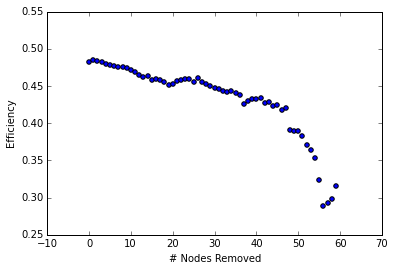

In [253]:
# # Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
# invpibmat = -1.0 * pibmat + 1.0
# invpibnet = nx.from_numpy_matrix(invpibmat)
# inp_fnet, inp_pnet = fnet.copy(), invpibnet.copy()

# # Run Simulation
# m, e = run_simulation(inp_fnet, inp_pnet, seed, 60)
# null_fnet = nx.Graph(np.array(nx.to_numpy_matrix(fnet.copy())))
# mnull, enull = run_simulation(null_fnet, inp_pnet, seed, 60)

# Plot Efficiencies
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(e)), e, c = 'b')
#ax.scatter(range(len(enull)), enull, c = 'g')
plt.xlabel('# Nodes Removed')
plt.ylabel('Efficiency')

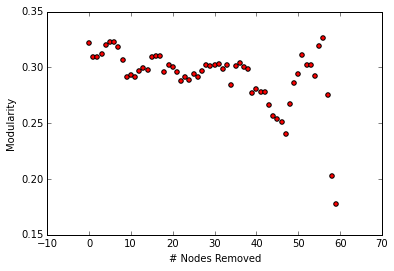

In [249]:
# Plot Modularities
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(m)), m, c = 'r')
#ax.scatter(range(len(mnull)), mnull, c = 'g')
plt.xlabel('# Nodes Removed')
plt.ylabel('Modularity')

Run Simulation with E4 Positive/Negative Subgroups
===========================
Use group level PiB network to simulat lesioning

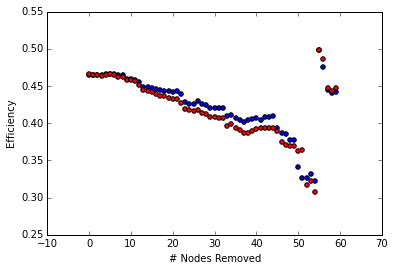

In [ ]:
# Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
invpibmat = -1.0 * pibmat + 1.0
invpibnet = nx.from_numpy_matrix(invpibmat)
inp_fnet_neg, inp_fnet_pos, inp_pnet = fnet_neg.copy(), fnet_pos.copy(), invpibnet.copy()

# Run Simulation
mpos, epos = run_simulation(inp_fnet_pos, inp_pnet, seed, 60)
mneg, eneg = run_simulation(inp_fnet_neg, inp_pnet, seed, 60) 

# Plot Efficiencies
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(epos)), epos, c = 'b')
ax.scatter(range(len(eneg)), eneg, c = 'r')
#ax.scatter(range(len(enull)), enull, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Efficiency')

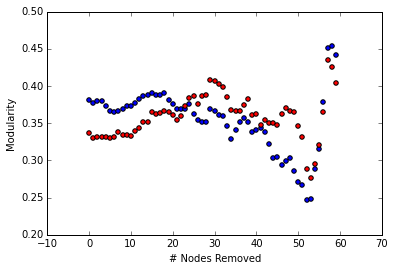

In [ ]:
# Plot Modularities
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(mpos)), mpos, c = 'b')
ax.scatter(range(len(mneg)), mneg, c = 'r')
#ax.scatter(range(len(mnull)), mnull, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Modularity')

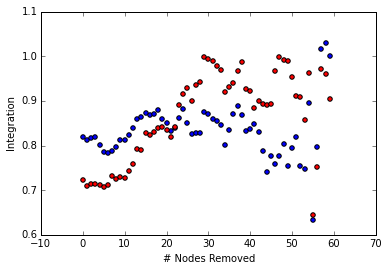

In [ ]:
# Integration = Modularity / Efficiency
integ_pos, integ_neg, integ_null = [], [], []

for i in range(len(mpos)):
    integ_pos.append(mpos[i] / epos[i])
    integ_neg.append(mneg[i] / eneg[i])
    #integ_null.append(mnull[i] / enull[i])

# Plot Integrations
fig = plt.figure()
ax = fig.add_subplot(111)

# Run simulation with E4 Positive Subjects
ax.scatter(range(len(integ_pos)), integ_pos, c = 'b')
ax.scatter(range(len(integ_neg)), integ_neg, c = 'r')
#ax.scatter(range(len(inte_null)), integ_null, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Integration')

Run Simulation with E4 Positive/Negative Subgroups
===========================
Use seperate subgrouplevel PiB networks to simulate lesioning

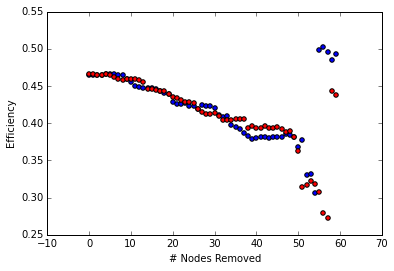

In [145]:
# Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
invpibmatpos = -1.0 * pibmatpos + 1.0
invpibnetpos = nx.from_numpy_matrix(invpibmatpos)

invpibmatneg = -1.0 * pibmatneg + 1.0
invpibnetneg = nx.from_numpy_matrix(invpibmatneg)

inp_fnet_neg, inp_fnet_pos, inp_pnet_pos, inp_pnet_neg = fnet_neg.copy(), fnet_pos.copy(), invpibnetpos.copy(), invpibnetneg.copy()

# Run Simulation
mpos, epos = run_simulation(inp_fnet_pos, inp_pnet_pos, seed, 60)
mneg, eneg = run_simulation(inp_fnet_neg, inp_pnet_neg, seed, 60) 

# Plot Efficiencies
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(epos)), epos, c = 'b')
ax.scatter(range(len(eneg)), eneg, c = 'r')

plt.ylabel('Efficiency')
plt.xlabel('# Nodes Removed')

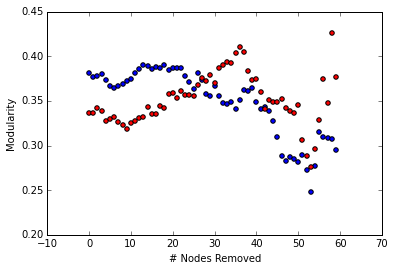

In [146]:
# Plot Modularity

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(mpos)), mpos, c = 'b')
ax.scatter(range(len(mneg)), mneg, c = 'r')

plt.ylabel('Modularity')
plt.xlabel('# Nodes Removed')

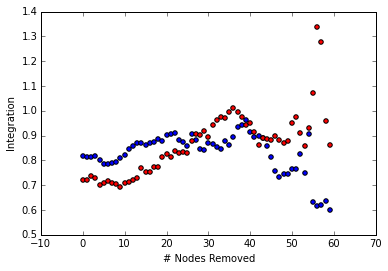

In [147]:
# Integration = Modularity / Efficiency
integ_pos, integ_neg = [], []

for i in range(len(mpos)):
    integ_pos.append(mpos[i] / epos[i])
    integ_neg.append(mneg[i] / eneg[i])

# Plot Integrations
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(integ_pos)), integ_pos, c = 'b')
ax.scatter(range(len(integ_neg)), integ_neg, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Integration')

~ 30 June 2015 ~

Run Simulation on Individual Subject Networks
========================
Might take a while

In [148]:
# Importing PiB Subject x Roi Data
pib_path = "/home/jagust/dino/graph/data/spreadsheets/pib/pib_summary_April2015.csv"
pib_dat = np.genfromtxt(pib_path, dtype = None)
pib_df = pd.DataFrame(pib_dat[1:], columns = pib_dat[0,:])
pib_df

,SUBID,scanner,ALL,Left-Amygdala,Left-Caudate,Left-Cerebellum-Cortex,Left-Hippocampus,Left-Pallidum,Left-Putamen,Left-Thalamus-Proper,...,ctx-rh-precentral,ctx-rh-precuneus,ctx-rh-rostralanteriorcingulate,ctx-rh-rostralmiddlefrontal,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-temporalpole,ctx-rh-transversetemporal
0,B05-201_v1,ecat,1.273208,1.086826,1.30695,0.914772,1.10575,1.485336,1.520339,1.438444,...,1.261181,1.678135,1.815939,1.585188,1.449524,1.305483,1.19165,1.427792,0.971381,1.427594
1,B05-201_v2,ecat,1.529529,1.262077,1.471517,1.007894,1.250078,1.762007,1.84082,1.644838,...,1.527978,1.896365,1.982312,1.949927,1.694613,1.550804,1.546884,1.80008,1.180847,1.722326
2,B05-202_v1,ecat,1.007444,0.996752,1.009585,0.925908,1.059822,1.432898,1.297446,1.411028,...,1.032836,1.068713,1.126808,0.943386,1.051736,1.005358,0.990789,1.001359,0.866243,1.216935
3,B05-215_v1,ecat,1.30598,1.127267,1.381074,0.942477,1.12963,1.582226,1.656856,1.536823,...,1.236287,1.516453,1.65888,1.654284,1.547849,1.320834,1.278834,1.478342,0.979637,1.422982
4,B05-215_v2,ecat,1.264717,1.147965,1.253538,0.95681,1.092281,1.621212,1.61515,1.485623,...,1.230727,1.265551,1.608417,1.601515,1.397909,1.113494,1.333598,1.406201,1.047203,1.470536
5,B05-216_v1,ecat,0.995555,1.023762,1.157034,0.94195,1.049361,1.231373,1.263895,1.337227,...,1.074021,1.043423,0.866399,0.91353,0.977341,1.025745,0.953268,1.010699,0.778639,0.98168
6,B05-216_v2,ecat,0.997904,1.150004,1.202634,0.945866,1.13584,1.311408,1.310684,1.524631,...,1.036295,0.997476,1.002954,0.933247,0.936901,1.003824,0.96584,0.927819,0.932658,0.983451
7,B05-217_v1,ecat,0.969352,1.028224,0.942836,0.936708,1.043872,1.284137,1.225581,1.307024,...,1.044124,0.999279,0.960506,0.883778,0.939117,0.955872,0.911645,0.93609,0.769666,1.090629
8,B05-217_v2,ecat,0.991589,0.989056,0.947241,1.051914,1.006267,1.297097,1.218044,1.368012,...,1.059234,0.992348,0.996284,0.911932,0.980789,0.997719,0.911317,0.95865,0.821811,1.095473
9,B05-229_v1,ecat,0.9856,0.983856,0.839358,0.882943,1.037109,1.137595,1.157793,0.999583,...,1.021045,1.107521,0.883888,0.968344,0.960292,1.004711,0.942215,0.917178,0.829615,1.04856


In [192]:
# Load Matrices
globstr = "/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/*"
mat_paths = sorted(glob(globstr))
#mat_paths

Subject: 1 out of: 342
Subject: 2 out of: 342
Subject: 3 out of: 342
Subject: 4 out of: 342
Subject: 5 out of: 342
Subject: 6 out of: 342
Subject: 7 out of: 342
Subject: 8 out of: 342
Subject: 9 out of: 342
Subject: 10 out of: 342
Subject: 11 out of: 342
Subject: 12 out of: 342


ValueError: NAN found in adjacency matrix, this will causeimproper behavior in sorting and improper results, please remove all nan 

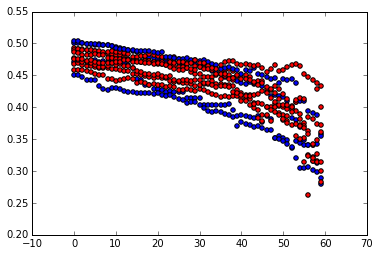

In [195]:
fig = plt.figure()
ax = fig.add_subplot(111)
sub = 1
stop = 60
for p in mat_paths[0:100]:
    print "Subject: " + str(sub) + " out of: " + str(len(mat_paths))
    sub += 1
    mat = np.load(p)
    thr_func_mat, c = util.threshold_adjacency_matrix(mat, cost = 0.20)
    ss = get_subsess(p)
    if type(is_geno_pos(ss)) == str:
        print "No geno data"
        continue
    elif is_geno_pos(ss):
        invpibmatpos = -1.0 * pibmatpos + 1.0
        invpibnetpos = nx.from_numpy_matrix(invpibmatpos)
        inp_pnet_pos = invpibnetpos.copy()
        
        # Run Simulation
        m, e = run_simulation(nx.Graph(thr_func_mat), inp_pnet_pos, seed, stop) 

        # Plot Efficiencies
        ax.scatter(range(len(e)), e, c = 'b')
    else:
        invpibmatneg = -1.0 * pibmatneg + 1.0
        invpibnetneg = nx.from_numpy_matrix(invpibmatneg)
        inp_pnet_neg = invpibnetneg.copy()
        
        # Run Simulation
        m, e = run_simulation(nx.Graph(thr_func_mat), inp_pnet_neg, seed, stop) 

        # Plot Efficiencies
        ax.scatter(range(len(e)), e, c = 'r')

plt.ylabel('Efficiency')
plt.xlabel('# Nodes Removed')

In [159]:
def get_subsess(path):
    direc = "/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/"
    ind1 = len(direc)
    ind2 = ind1 + 18
    return path[ind1:ind2]
def is_geno_pos(ss):
    if len(ss) > 7:
        num_copies = subject_summary[subject_summary.Subsess == ss].values[0][6]
        if num_copies not in [0, 1, 2]:
            print "No genotype data: " + find_id(ss)
            return'x'
        else:
            return num_copies > 0.0
    else:
        num_copies = subject_summary[subject_summary.LBLID == ss].values[0][6]
        if num_copies not in [0, 1, 2]:
            print "No genotype data: " + find_id(ss)
            return
        else:
            return num_copies > 0.0

In [162]:
master_subject_path = "/home/jagust/dino/graph/data/mri1.5/rest/master_subject_summary.xlsx"
subject_summary = pd.ExcelFile(master_subject_path).parse("Sheet1")
subject_summary

,Subsess,LBLID,Birthday,Age,Gender,Edu,E4_Copies,MRI_Magnet,MRI_TR,MRI_Timepoints,MRI_directory,MRI_arda_dir,MRI_date,PIB_bacs_dir,PIB_bacs_date,FDG_bacs_dir,FDG_bacs_date,Cog_dir,Cog_date
0,B05-201_2009-03-27,B05-201,1933-07-14,75,F,20,1,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-201_20...,/home/jagust/arda/lblid/B05-201/MRI_1.5_2009-0...,2009-03-27,/home/jagust/bacs_pet/PIB/old/ecat/B05-201_v1/pib,2009-03-23,/home/jagust/bacs_pet/FDG/old/ecat/B05-201_v1/fdg,2009-03-23,/home/jagust/arda/lblid/B05-201/COG_S2_2009-08...,2009-08-24
1,B05-201_2013-09-17,B05-201,1933-07-14,80,F,20,1,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-201_20...,/home/jagust/arda/lblid/B05-201/MRI3_1.5_2013-...,2013-09-17,/home/jagust/bacs_pet/PIB/old/ecat/B05-201_v2/pib,2013-11-06,/home/jagust/bacs_pet/FDG/old/ecat/B05-201_v2/fdg,2013-11-06,/home/jagust/arda/lblid/B05-201/COG_S4_2013-06...,2013-06-26
2,B05-202_2009-06-09,B05-202,1928-07-28,80,F,17,0,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-202_20...,/home/jagust/arda/lblid/B05-202/MRI_1.5_2009-0...,2009-06-09,/home/jagust/bacs_pet/PIB/old/ecat/B05-202_v1/pib,2009-06-02,/home/jagust/bacs_pet/FDG/old/ecat/B05-202_v1/fdg,2009-06-02,/home/jagust/arda/lblid/B05-202/COG_S2_2009-07...,2009-07-15
3,B05-202_2012-11-16,B05-202,1928-07-28,84,F,17,0,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-202_20...,/home/jagust/arda/lblid/B05-202/MRI2_1.5_2012-...,2012-11-16,/home/jagust/bacs_pet/PIB/old/ecat/B05-202_v1/pib,2009-06-02,/home/jagust/bacs_pet/FDG/old/ecat/B05-202_v1/fdg,2009-06-02,/home/jagust/arda/lblid/B05-202/COG_S5_2012-09...,2012-09-12
4,B05-215_2008-10-01,B05-215,1938-06-21,70,F,20,2,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-215_20...,/home/jagust/arda/lblid/B05-215/MRI_1.5_2008-1...,2008-10-01,/home/jagust/bacs_pet/PIB/old/ecat/B05-215_v1/pib,2008-10-06,/home/jagust/bacs_pet/FDG/old/ecat/B05-215_v1/fdg,2008-10-06,/home/jagust/arda/lblid/B05-215/COG_S3_2009-07...,2009-07-09
5,B05-215_2010-09-03,B05-215,1938-06-21,72,F,20,2,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-215_20...,/home/jagust/arda/lblid/B05-215/MRI2_1.5_2010-...,2010-09-03,/home/jagust/bacs_pet/PIB/old/ecat/B05-215_v2/pib,2010-09-09,/home/jagust/bacs_pet/FDG/old/ecat/B05-215_v2/fdg,2010-09-14,/home/jagust/arda/lblid/B05-215/COG_S4_2011-07...,2011-07-26
6,B05-216_2008-10-07,B05-216,1941-09-01,67,F,18,0,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-216_20...,/home/jagust/arda/lblid/B05-216/MRI_1.5_2008-1...,2008-10-07,/home/jagust/bacs_pet/PIB/old/ecat/B05-216_v1/pib,2008-11-20,/home/jagust/bacs_pet/FDG/old/ecat/B05-216_v1/fdg,2008-10-29,/home/jagust/arda/lblid/B05-216/COG_S3_2009-05...,2009-05-18
7,B05-216_2013-08-20,B05-216,1941-09-01,71,F,18,0,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-216_20...,/home/jagust/arda/lblid/B05-216/MRI2_1.5_2013-...,2013-08-20,/home/jagust/bacs_pet/PIB/old/ecat/B05-216_v2/pib,2013-08-15,/home/jagust/bacs_pet/FDG/old/ecat/B05-216_v2/fdg,2013-08-15,/home/jagust/arda/lblid/B05-216/COG_S5_2013-06...,2013-06-07
8,B05-217_2009-03-16,B05-217,1937-10-10,71,M,18,0,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-217_20...,/home/jagust/arda/lblid/B05-217/MRI_1.5_2009-0...,2009-03-16,/home/jagust/bacs_pet/PIB/old/ecat/B05-217_v1/pib,2009-03-18,/home/jagust/bacs_pet/FDG/old/ecat/B05-217_v1/fdg,2009-03-18,/home/jagust/arda/lblid/B05-217/COG_S3_2009-05...,2009-05-07
9,B05-217_2010-03-12,B05-217,1937-10-10,72,M,18,0,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-217_20...,/home/jagust/arda/lblid/B05-217/MRI2_1.5_2010-...,2010-03-12,/home/jagust/bacs_pet/PIB/old/ecat/B05-217_v1/pib,2009-03-18,/home/jagust/bacs_pet/FDG/old/ecat/B05-217_v1/fdg,2009-03-18,/home/jagust/arda/lblid/B05-217/COG_S3_2009-05...,2009-05-07


Testing Written Functions
==========

In [29]:
toy = nx.Graph()

In [30]:
toy.add_edges_from([(1, 2, {'weight' : 0.1}), (1, 3, {'weight' : 0.2}), (2, 4, {'weight' : .2}), (3, 4, {'weight' : .3})]) 

In [31]:
toy.add_edge(1, 4, {'weight' : 0.05})
toy.add_edge(1, 5, {'weight' : 0.01})
toy.add_edge(5, 4, {'weight' : 0.02})
r = {4, 5}
n = find_next_node(r, toy)
n

1

In [32]:
toy.edges(data=True)

[(1, 2, {'weight': 0.1}),
 (1, 3, {'weight': 0.2}),
 (1, 4, {'weight': 0.05}),
 (1, 5, {'weight': 0.01}),
 (2, 4, {'weight': 0.2}),
 (3, 4, {'weight': 0.3}),
 (4, 5, {'weight': 0.02})]

In [41]:
toy.add_edge(1, 6, {'weight' : -0.5})
remove_neg_weight_edges(toy)
toy.edges(data=True)

[(1, 2, {'weight': 0.1}),
 (1, 3, {'weight': 0.2}),
 (1, 4, {'weight': 0.05}),
 (1, 5, {'weight': 0.01}),
 (1, 6, {'weight': -0.5}),
 (2, 4, {'weight': 0.2}),
 (3, 4, {'weight': 0.3}),
 (4, 5, {'weight': 0.02})]

In [74]:
toy.nodes()

[1, 2, 3, 4, 5]

In [48]:
remove_neg_weight_edges(toy)
toy.edges(data=True)

[(1, 2, {'weight': 0.1}),
 (1, 3, {'weight': 0.2}),
 (1, 4, {'weight': 0.05}),
 (1, 5, {'weight': 0.01}),
 (2, 4, {'weight': 0.2}),
 (3, 4, {'weight': 0.3}),
 (4, 5, {'weight': 0.02})]

In [214]:
mat = btc.randomizer_bin_und(thr_func_mat, .99)

In [215]:
g = nx.Graph(mat)
len(g.edges(data=True))

670

In [208]:
thr_func_mat

array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False]], dtype=bool)

In [209]:
g = nx.from_numpy_matrix(thr_func_mat)
len(g.edges(data=True))

632

In [237]:
def rand_graph(g):
    mat = nx.to_numpy_matrix(g)
    return btc.randomizer_bin_und(np.array(mat), 0.99)

In [238]:
g = rand_graph(nx.Graph(thr_func_mat))

(array([  1.,   1.,   2.,  13.,   5.,   9.,  14.,  19.,   6.,  10.]),
 array([  3. ,   5.2,   7.4,   9.6,  11.8,  14. ,  16.2,  18.4,  20.6,
         22.8,  25. ]),
 <a list of 10 Patch objects>)

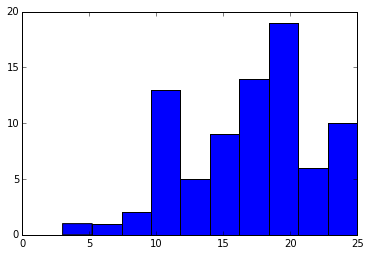

In [239]:
plt.hist(nx.Graph(g).degree().values())

(array([  2.,   0.,  10.,   8.,   4.,  12.,  22.,   7.,   9.,   6.]),
 array([  3. ,   5.2,   7.4,   9.6,  11.8,  14. ,  16.2,  18.4,  20.6,
         22.8,  25. ]),
 <a list of 10 Patch objects>)

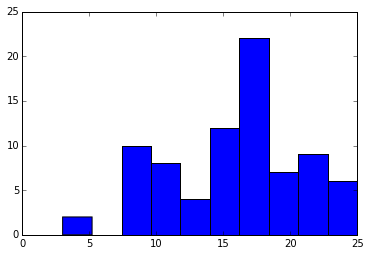

In [240]:
plt.hist(nx.Graph(thr_func_mat).degree().values())